# Point observations

In order to skill assess our model, we need observational data. The data may come from a file or web api. We will cover the following situations here: 

* File
    - dfs0
    - csv/excel
    - NetCDF
* REST API

modelskill has the class [PointObservation](https://dhi.github.io/fmskill/api.html#fmskill.observation.PointObservation) for working with point observations. 

Point observations consist of time-value-pairs (data) and *meta* data such as

* data type (e.g. water level)
* unit (e.g. meter)
* position (coordinates + coordinate reference system)

ModelSkill ll ll is agnostic to the coordinate reference system (CRS) and it is therefore the responsibility of the user to make sure that all data (observations and model) use the same CRS.

In [17]:
import modelskill as ms

## Observations from dfs0

Dfs0 files are obviously a very common container format for point observation data at DHI. Besides the data (time-value-pairs), it typically contains meta data information about the data type (EUM type, e.g. water level) and data unit (EUMUnit, e.g. meter). It can potentially store geographical information too, but this is rarely the case. We typically need to provide this information ourselves.

In [2]:
fn = 'data/SW/HKNA_Hm0.dfs0'
pos = (4.2420, 52.6887)   # LONG/LAT

## The PointObservation class

The PointObservation class can be instantiated with a dfs0 file name, the item, the position and optionally also a user-defined name.

PointObservation has basic properties like start_time, end_time, n_points, name, etc

PointObservation has two simple plot methods:

* plot() - a time series plot
* hist() - a histogram

Note that the PointObservation object takes a single item only. 

In [18]:
o1 = ms.PointObservation(fn, item=0, x=pos[0], y=pos[1], name="HKNA_from_dfs0")
o1

PointObservation: HKNA_from_dfs0, x=4.242, y=52.6887

In [4]:
o1.start_time, o1.end_time

(Timestamp('2017-10-26 00:10:00'), Timestamp('2017-10-29 23:50:00'))

In [5]:
o1.n_points

564

In [7]:
o1.quantity

Quantity(name='Significant wave height', unit='meter')

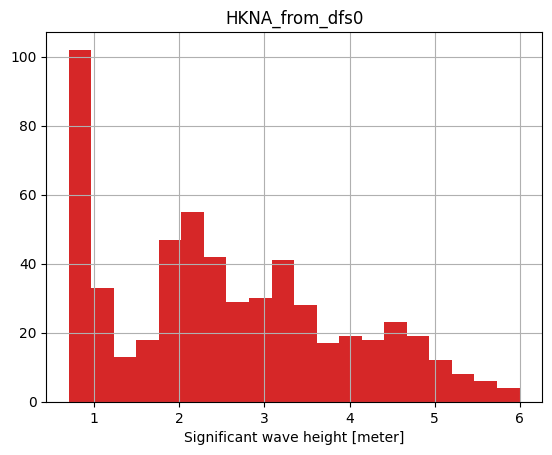

In [9]:
o1.plot.hist(bins=20);

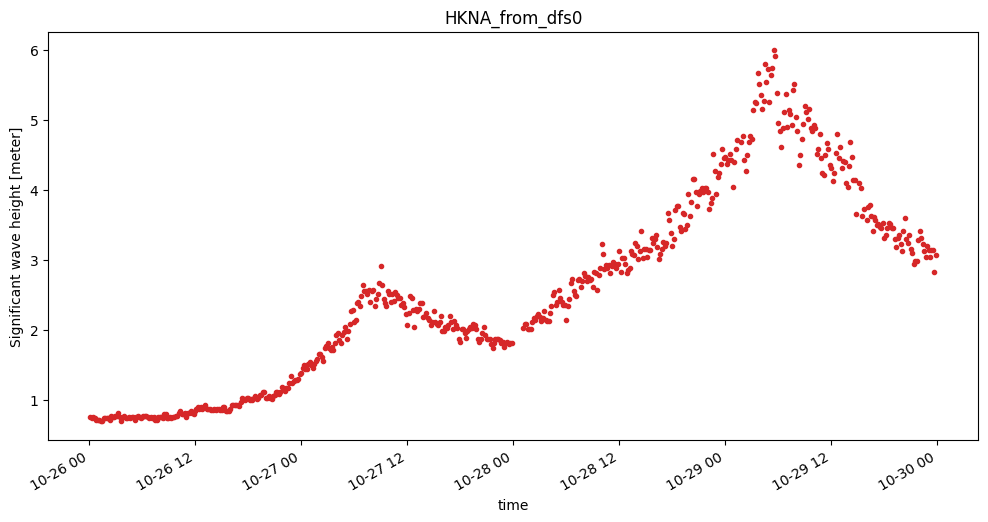

In [10]:
o1.plot(figsize=(12,6));

## Observations from csv/excel

Pandas is our friend. FMSkill PointObservation can be initialized with either a dfs0 or a pandas DataFrame. Hence, for other file types than dfs0 the workflow is to first create a DataFrame with the data e.g. using pd.read_csv() or pd.read_excel(). 

You need to provide the **position** and preferably also **EUM info** (for nice plotting). 

In [21]:
import pandas as pd
df = pd.read_csv('data/SW/HKNA_Hm0.csv', index_col=0, parse_dates=True)   # make sure index is DateTimeIndex!
df.head()

,Hm0
time,
2017-10-26 00:10:00,0.76172
2017-10-26 00:20:00,0.74219
2017-10-26 00:30:00,0.76172
2017-10-26 00:40:00,0.74219
2017-10-26 00:50:00,0.72266


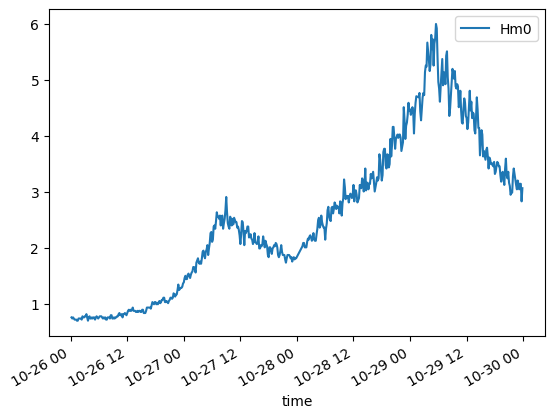

In [22]:
df.plot();

In [27]:
o2 = ms.PointObservation(df, item="Hm0", x=pos[0], y=pos[1],
                          name='Hm0_from_csv',
                          quantity=ms.Quantity('Significant wave height', 'm'))

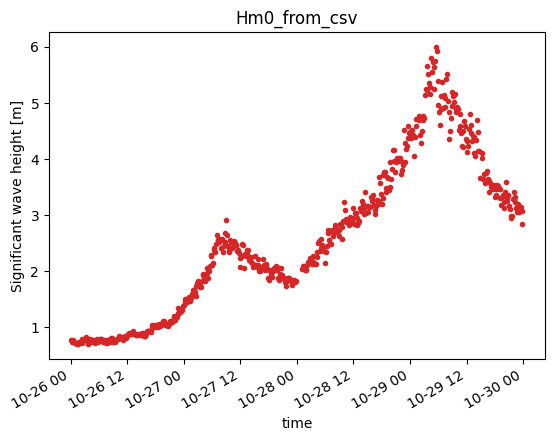

In [28]:
o2.plot();

## Observations from NetCDF

A NetCDF file is best handled with xarray. It often contains meta data that you can use for constructing your point observation object.

In [29]:
import xarray as xr
ds = xr.open_dataset('data/SW/Europlatform2.nc')
ds

<xarray.Dataset>
Dimensions:      (TIME: 1008, DEPTH: 2, LATITUDE: 4464, LONGITUDE: 4464,
                  POSITION: 4464)
Coordinates:
  * TIME         (TIME) datetime64[ns] 2017-10-25 ... 2017-10-31T23:50:00
  * LATITUDE     (LATITUDE) float32 52.0 52.0 52.0 52.0 ... 52.0 52.0 52.0 52.0
  * LONGITUDE    (LONGITUDE) float32 3.276 3.276 3.276 ... 3.276 3.276 3.276
Dimensions without coordinates: DEPTH, POSITION
Data variables: (12/18)
    TIME_QC      (TIME) float32 ...
    DEPH         (TIME, DEPTH) float32 ...
    DEPH_QC      (TIME, DEPTH) float32 ...
    POSITION_QC  (POSITION) float32 ...
    VAVH         (TIME, DEPTH) float64 ...
    VAVH_QC      (TIME, DEPTH) float32 ...
    ...           ...
    VTZA         (TIME, DEPTH) float64 ...
    VTZA_QC      (TIME, DEPTH) float32 ...
    TEMP         (TIME, DEPTH) float64 ...
    TEMP_QC      (TIME, DEPTH) float32 ...
    SWHT         (TIME, DEPTH) float64 ...
    SWHT_QC      (TIME, DEPTH) float32 ...
Attributes: (12/51)
    data_type:                      OceanSITES time-series data
    platform_code:                  Europlatform2
    platform_name:                  
    institution:                    Rijkswaterstaat Water Traffic and Environ...
    institution_edmo_code:          1526
    wmo_platform_code:              
    ...                             ...
    data_assembly_center:           BSH
    wmo_inst_type:                  
    id:                             NO_TS_MO_Europlatform2_201710
    title:                          NWS - NRT in situ Observations
    history:                        2020-01-22T12:14:28Z : Creation; 2020-11-...
    date_update:                    2021-02-26T13:39:19Z

In [30]:
pos = ds.LONGITUDE.values[0], ds.LATITUDE.values[0]
pos

(3.276389, 51.99861)

In [31]:
ds.VHM0.isel(DEPTH=0)

<xarray.DataArray 'VHM0' (TIME: 1008)>
[1008 values with dtype=float64]
Coordinates:
  * TIME     (TIME) datetime64[ns] 2017-10-25 ... 2017-10-31T23:50:00
Attributes: (12/16)
    long_name:           Spectral significant wave height (Hm0)
    standard_name:       sea_surface_wave_significant_height
    units:               m
    valid_min:           1
    valid_max:           30000
    type_of_analysis:    spectral analysis
    ...                  ...
    resolution:           
    cell_methods:         
    sensor_depth:        0.0
    sensor_mount:         
    sensor_orientation:   
    data_mode:           R

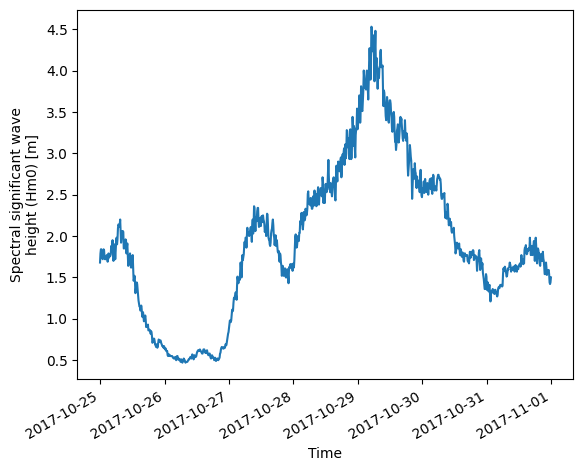

In [32]:
ds.VHM0.isel(DEPTH=0).plot();

In [46]:
df = ds.VHM0.isel(DEPTH=0).to_dataframe()
df.index = df.index.strftime('%Y-%m-%d %H:%M:%S')
df.head()

,VHM0
TIME,
2017-10-25 00:00:00,1.68
2017-10-25 00:10:00,1.79
2017-10-25 00:20:00,1.84
2017-10-25 00:30:00,1.84
2017-10-25 00:40:00,1.76


In [37]:
o3 = ms.PointObservation(ds.VHM0.isel(DEPTH=0), x=pos[0], y=pos[1], name='Hm0_from_nc')

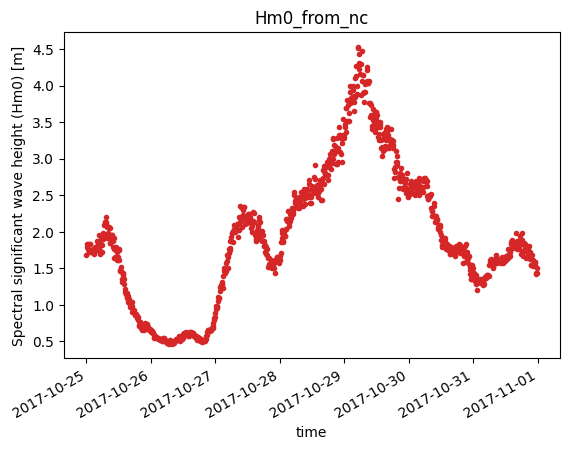

In [47]:
o3.plot();